# <center><font color="yellow">PUBG Game prediction</font></center>

<center><img src="https://media.giphy.com/media/XEGcqYkhhj5aQ8Yz1I/giphy.gif?cid=790b76116amyen5lj4s6jp6nm6go7ng54ixwkktva11emnol&ep=v1_gifs_search&rid=giphy.gif&ct=g"></center>

# Table Contents
1 -Importing Libraries<br>
2 -Reading Data<br>
3 -Data Wrangling<br>
4 -Feature Engineering<br>
5 -ML - CatBoost Model<br>

# Importing libraries

In [5]:
#standard libraries
import numpy as np
import pandas as pd

#visualistion
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"]=(16,6)

import seaborn as sns

#handling warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
!pip install catboost
#conda install -c conda-forge catboost

In [6]:
import catboost as cb

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [8]:
df= pd.read_csv("PUBG_Game_Prediction_data.csv")

In [9]:
df.head(5)
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [35]:
df.shape

(4446966, 29)

### Data Description

- *DBNOs*: Number of enemy players knocked.
-a*Assists*: Number of enemy players this player damaged that were killed by teammates.
b *Boosts*: Number of boost items used.
d- *DamageDealt*: Total damage dealt. Note: Self-inflicted damage is subtracted.h
- *HeadshotKills*: Number of enemy players killed with headshotsh
- *Heals*: Number of healing items usei.
- *Id*: Player’s kd.
- *KillPlace*: Ranking in match of number of enemy players kilked.
- *KillPoints*: Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “Nkne”.
- *KillStreaks*: Max number of enemy players killed in a short amount ofktime.
- *Kills*: Number of enemy players lilled.
- *LongestKill*: Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKiml stat.
- *MatchDuration*: Duration of match inmseconds.
- *MatchId*: ID to identify match. There are no matches that are in both the training and temting set.
- *MatchType*: String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custrm matches.
- *RankPoints*: Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes placr of “None”.
- *Revives*: Number of times this player revivrd teammates.
- *RideDistance*: Total distance traveled in vehicles measured in meters.
- *RoadKills*: Number of kills whils in a vehicle.
- *SwimDistance*: Total distance traveled by swimming meatured in meters.
- *TeamKills*: Number of times this player kvlled a teammate.
- *VehicleDestroys*: Number of vwhicles destroyed.
- *WalkDistance*: Total distance traveled on foot weasured in meters.
- *WeaponsAcquired*: Number ow weapons picked up.
- *WinPoints*: Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should begtreated as a “None”.
- *GroupId*: ID to identify a group within a match. If the same group of players plays in different matches, they will have a differnnt groupId each time.
- *NumGroups*: Number of groups we havemdata for in the match.
- *MaxPlace*: Worst placement we have data for in the match. This may not match with numGroups, as sometimes the datw skips over placements.
- *WinPlacePerc*: The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# Data Wrangling

In [37]:
#check for the rows with null win prediction
df[df['winPlacePerc'].isnull()]# will return those values for which "df['winPlacePerc'].isnull()" is true

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [39]:
df.drop(2744604, inplace=True)
#df=df.drop(2744604)

In [41]:
#prepare new parameter to know how many players are in a game
df['playersJoined']=df.groupby('matchId')['matchId'].transform('count')

In [43]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


In [45]:
#sns.countplot(df[df['playersJoined']>=75]['playersJoined'])
#plt.show()

Analysing The Data 

Kill without Moving?

<center><img src="https://media.giphy.com/media/93hVNoTJ2gEBhQ0jLO/giphy.gif?cid=ecf05e476xc7fno5v7ti00e36yw4tmty279fd93p2pelwyws&ep=v1_gifs_search&rid=giphy.gif&ct=g"></center>

In [47]:
#prepare a data parameter to gather the information of the total distance travelled
df['totalDistance']=df['rideDistance']+df['walkDistance']+df['swimDistance']

#prepare a data parameter to check for anamoly detection that the person has not moved but killed
df['killswithoutMoving']=((df['kills']>0)&(df['totalDistance']==0))

In [49]:
df[df['killswithoutMoving']==True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killswithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


In [51]:
df[df['killswithoutMoving']==True].shape

(1535, 32)

In [53]:
df.drop(df[df['killswithoutMoving']==True].index, inplace=True)

Extra-ordinary Road kills?

<center><img src="https://media.giphy.com/media/4zalOhkBdrxEPFkqoN/giphy.gif?cid=790b76118fwossfnhxn9fwmdjql8rrrkhqq15aoxsr4m7v9l&ep=v1_gifs_search&rid=giphy.gif&ct=g"></center>

In [61]:
df[df['roadKills'] > 5].shape

(0, 32)

In [57]:
df[df['roadKills']>5].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killswithoutMoving
39338,0097d2ae7a8576,b61edfa0c228d4,a786011fe206e9,1,2,495.7,4,0,0,2,...,0.0,0,0,72.80,1,0,0.9362,92,5202.80,False
90312,0e6ea81fd1b9b3,1e96ac916d6fbb,3f150f3834422c,2,6,190.0,0,0,5,2,...,0.0,0,1,976.80,4,0,0.9556,89,4257.80,False
197752,6cf1efa197bcc1,28df010b29a9e2,2e40495266529f,0,2,800.0,5,0,4,1,...,0.0,0,0,1516.00,3,0,0.6538,89,10085.00,False
209676,5df28fce2b8128,32a01a5517635a,ee9fb50eb0fe00,0,3,360.0,2,0,4,1,...,0.0,0,0,36.96,0,0,1.0000,59,6142.96,False
213544,612ee3024560a3,ab0162b0300c59,7c5535bfd43592,1,2,426.3,3,0,0,1,...,0.0,0,0,128.30,3,0,0.9167,96,3607.30,False


In [59]:
df=df.drop(df[df['roadKills']>5].index)

So many KILLS- HOW?

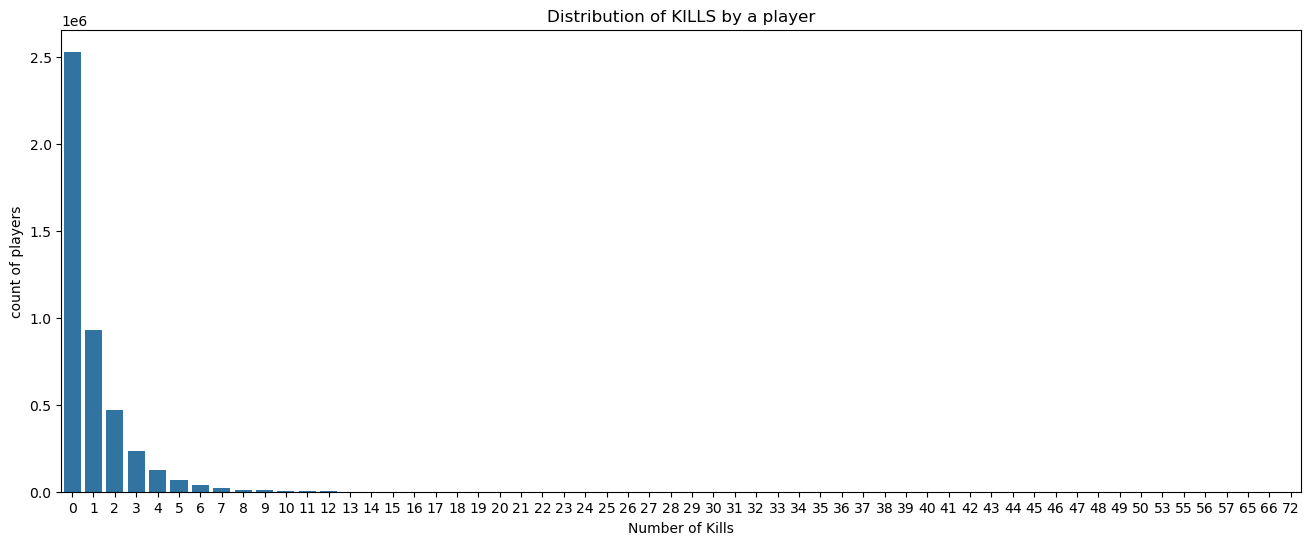

In [63]:
sns.countplot(data=df, x=df['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("count of players")
plt.xlabel("Number of Kills")
plt.show()

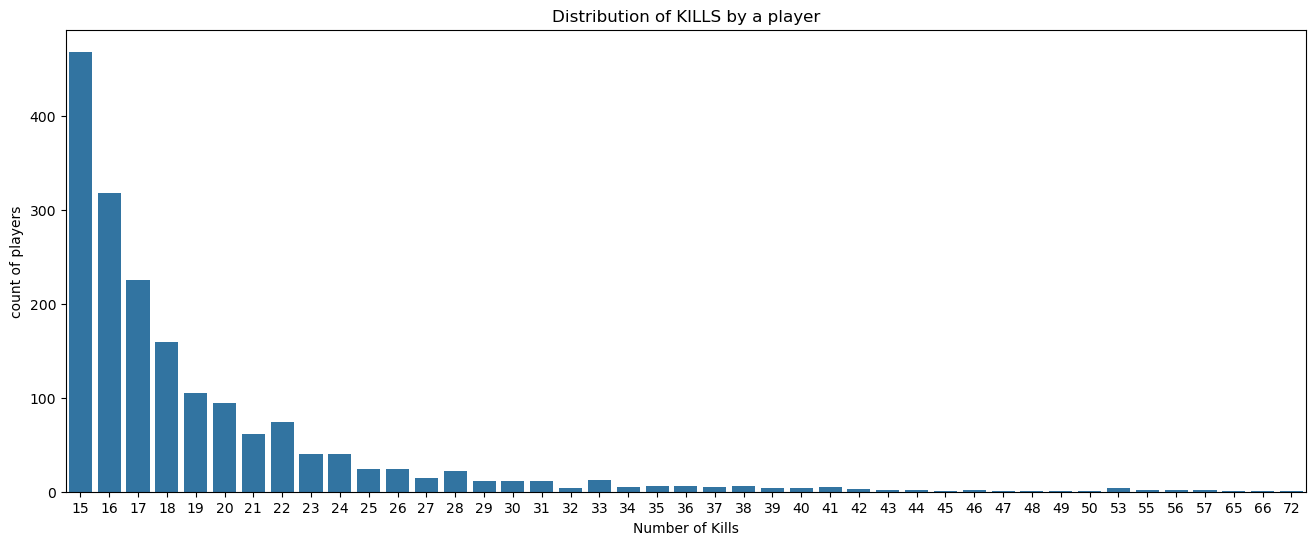

In [65]:
sns.countplot(x=df[df['kills']>=15]['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("count of players")
plt.xlabel("Number of Kills")
plt.show()

In [67]:
# data dimension
df[df['kills'] > 20].shape

(417, 32)

In [69]:
df=df.drop(df[df['kills']>20].index)
#df.drop(df[df['kills']>20].index, inplace=True)

Headshot

<center><img src="https://media.giphy.com/media/xT0xeNaiTQjRpZkpZ6/giphy.gif?cid=790b7611y1vz7590cbhxrmq2bjtemd2s1v1gp75bi7yunb7z&ep=v1_gifs_search&rid=giphy.gif&ct=g"></center>

In [73]:
df['headshot_rate']=df['headshotKills']/df['kills']
df['headshot_rate']=df['headshot_rate'].fillna(0)

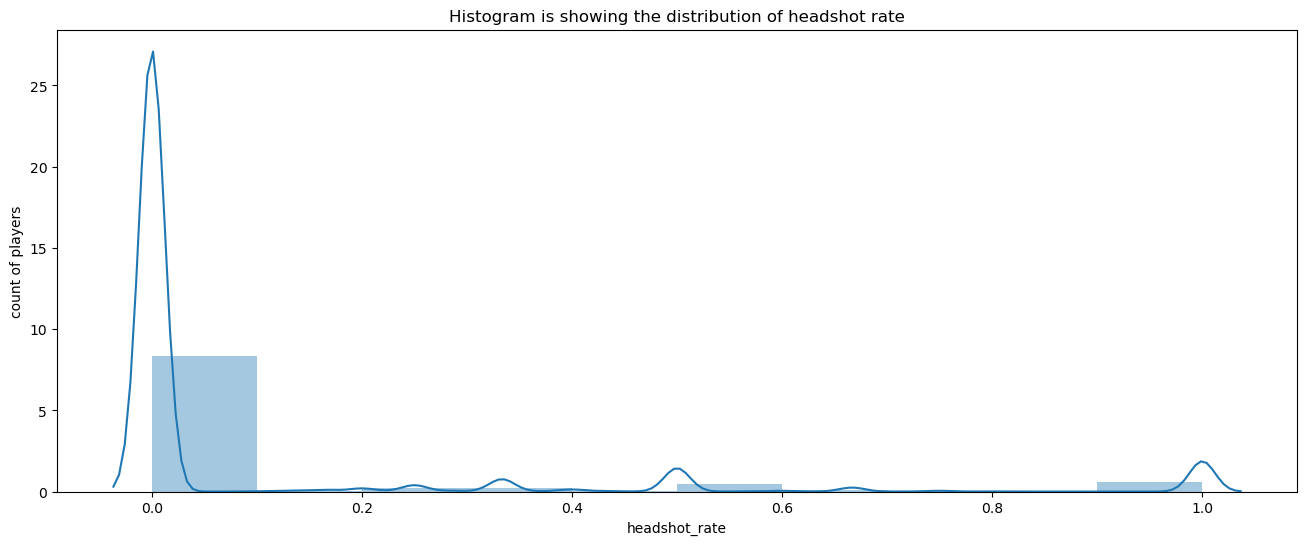

In [75]:
sns.distplot(df['headshot_rate'], bins=10).set_title("Histogram is showing the distribution of headshot rate")
plt.ylabel("count of players")
plt.show()

In [76]:
df[(df['headshot_rate']==1) & (df['kills']>5)].shape

(187, 33)

In [79]:
df.drop(df[(df['headshot_rate']==1) & (df['kills']>5)].index, inplace=True)

Longest shot

<center><img src="https://media1.tenor.com/m/mI56yU5i-nYAAAAd/2kills-kill.gif"></center>

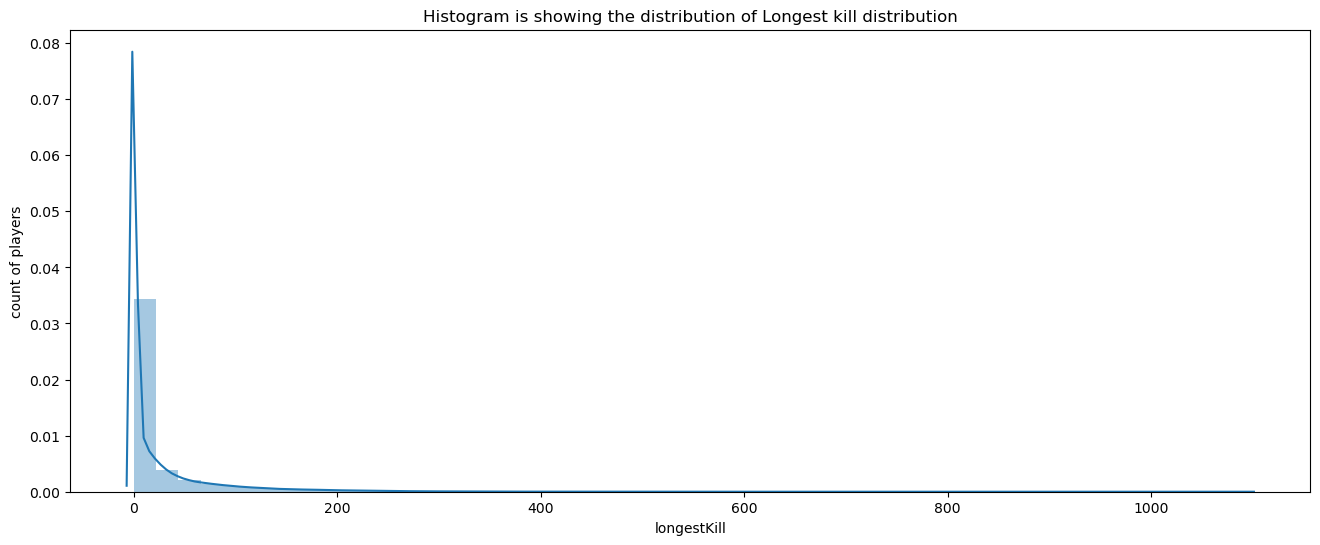

In [81]:
sns.distplot(df['longestKill'], bins=50).set_title("Histogram is showing the distribution of Longest kill distribution")
plt.ylabel("count of players")
plt.show()

In [82]:
df[df['longestKill']>500].shape

(1736, 33)

In [87]:
df.drop(df[df['longestKill']>500].index, inplace=True)

Weapon Change

<center><img src="https://media4.giphy.com/media/QCC0h2pdbvGN5JTBmk/100.webp"></center>

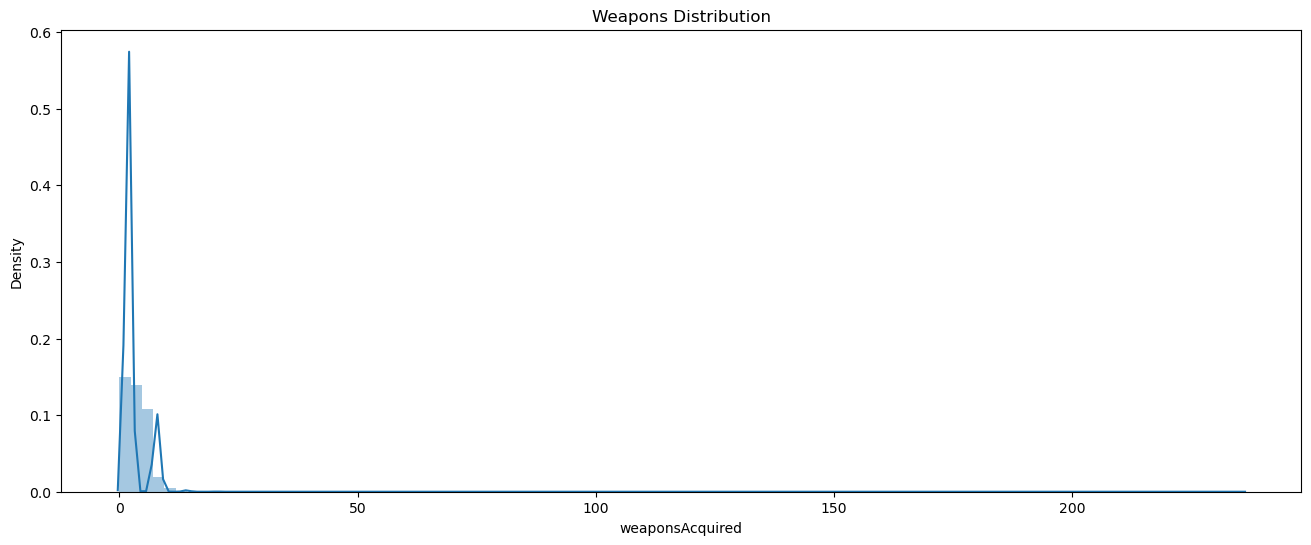

In [89]:
sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [90]:
df[df['weaponsAcquired']>=15].shape

(6809, 33)

In [91]:
df.drop(df[df['weaponsAcquired']>=15].index, inplace=True)

EDA

In [92]:
df.shape

(4436235, 33)

In [93]:
df.isna().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
dtype: int64

In [99]:
df.head()


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killswithoutMoving,headshot_rate
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0,244.80,1,1466,0.4444,96,244.8000,False,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0,1434.00,5,0,0.6400,91,1445.0445,False,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0,161.80,2,0,0.7755,98,161.8000,False,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0,202.70,3,0,0.1667,91,202.7000,False,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0,49.75,2,0,0.1875,97,49.7500,False,0.0


In [102]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutMoving', 'headshot_rate'],
      dtype='object')

In [225]:
#correlation of parameter with win prediction
#plt.figure(figsize=[30,30])
#sns.heatmap(df.corr(), annot=True)
#plt.show()#maybe we have to drop the id, groupid, and match id

# Feature Engineering

In [106]:
normalising_factor = (100-df['playersJoined']/100)+1

In [108]:
df['killsNorm']=df['kills']*normalising_factor
df['damageDealtNorm']=df['damageDealt']*normalising_factor
df['maxPlaceNorm']=df['maxPlace']*normalising_factor
df['matchDurationNorm']=df['matchDuration']*normalising_factor

df['traveldistance']=df['walkDistance']+df['swimDistance']+df['rideDistance']
df['healsnboosts']=df['heals']+df['boosts']
df['assist']=df['assists']+df['revives']

In [110]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutMoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsnboosts', 'assist'],
      dtype='object')

In [116]:
data=df.drop(columns=['Id', 'groupId', 'matchId','assists', 'boosts', 'walkDistance', 'swimDistance',
                     'rideDistance','heals', 'revives','kills','damageDealt','maxPlace','matchDuration'])

In [118]:
data.columns

Index(['DBNOs', 'headshotKills', 'killPlace', 'killPoints', 'killStreaks',
       'longestKill', 'matchType', 'numGroups', 'rankPoints', 'roadKills',
       'teamKills', 'vehicleDestroys', 'weaponsAcquired', 'winPoints',
       'winPlacePerc', 'playersJoined', 'totalDistance', 'killswithoutMoving',
       'headshot_rate', 'killsNorm', 'damageDealtNorm', 'maxPlaceNorm',
       'matchDurationNorm', 'traveldistance', 'healsnboosts', 'assist'],
      dtype='object')

In [120]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,killswithoutMoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


# ML - catboost Model

Handling categorical data

In [122]:
x= data.drop(['winPlacePerc'], axis=1)#or we can drop like above in columns
y=data['winPlacePerc']

In [124]:
x.shape

(4436235, 25)

In [128]:
x['matchType'].unique()

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-squad', 'crashtpp',
       'normal-solo', 'normal-duo'], dtype=object)

In [130]:
#x=pd.get_dummies(x, columns=['matchType', 'killswithoutMoving'])#one hot encoding
x['killswithoutMoving'].dtype

dtype('bool')

In [132]:
x['killswithoutMoving'].isnull().sum()

0

In [134]:
x['killswithoutMoving'] = x['killswithoutMoving'].astype(int)

In [136]:
print(x['matchType'].head())

0    squad-fpp
1    squad-fpp
2          duo
3    squad-fpp
4     solo-fpp
Name: matchType, dtype: object


In [138]:
x.isnull().sum()

DBNOs                 0
headshotKills         0
killPlace             0
killPoints            0
killStreaks           0
longestKill           0
matchType             0
numGroups             0
rankPoints            0
roadKills             0
teamKills             0
vehicleDestroys       0
weaponsAcquired       0
winPoints             0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
killsNorm             0
damageDealtNorm       0
maxPlaceNorm          0
matchDurationNorm     0
traveldistance        0
healsnboosts          0
assist                0
dtype: int64

In [140]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

print("Initial null values in the DataFrame:")
print(x.isnull().sum())

Initial null values in the DataFrame:
DBNOs                 0
headshotKills         0
killPlace             0
killPoints            0
killStreaks           0
longestKill           0
matchType             0
numGroups             0
rankPoints            0
roadKills             0
teamKills             0
vehicleDestroys       0
weaponsAcquired       0
winPoints             0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
killsNorm             0
damageDealtNorm       0
maxPlaceNorm          0
matchDurationNorm     0
traveldistance        0
healsnboosts          0
assist                0
dtype: int64


In [142]:
# Proceed with one-hot encoding
encoder = OneHotEncoder()
match_types_encoded = encoder.fit_transform(x[['matchType']])

In [144]:
# Get feature names based on categories
feature_names = encoder.get_feature_names_out(['matchType'])

In [146]:
match_types_encoded_df = pd.DataFrame(match_types_encoded.toarray(), columns=feature_names,index=x.index)#index=x.index is important to not include null values in x

In [148]:
# Check for null values in the encoded DataFrame
print("Null values in encoded DataFrame:")
print(match_types_encoded_df.isnull().sum())

Null values in encoded DataFrame:
matchType_crashfpp            0
matchType_crashtpp            0
matchType_duo                 0
matchType_duo-fpp             0
matchType_flarefpp            0
matchType_flaretpp            0
matchType_normal-duo          0
matchType_normal-duo-fpp      0
matchType_normal-solo         0
matchType_normal-solo-fpp     0
matchType_normal-squad        0
matchType_normal-squad-fpp    0
matchType_solo                0
matchType_solo-fpp            0
matchType_squad               0
matchType_squad-fpp           0
dtype: int64


In [150]:
x.shape

(4436235, 25)

In [154]:
# Check for null values in original DataFrame before concatenation
print("Null values in the original DataFrame before concatenation:")
print(x.isnull().sum())

Null values in the original DataFrame before concatenation:
DBNOs                 0
headshotKills         0
killPlace             0
killPoints            0
killStreaks           0
longestKill           0
matchType             0
numGroups             0
rankPoints            0
roadKills             0
teamKills             0
vehicleDestroys       0
weaponsAcquired       0
winPoints             0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
killsNorm             0
damageDealtNorm       0
maxPlaceNorm          0
matchDurationNorm     0
traveldistance        0
healsnboosts          0
assist                0
dtype: int64


In [160]:
# Concatenate encoded columns back to original DataFrame and drop the original matchType column
x =pd.concat([x, match_types_encoded_df], axis=1).drop(['matchType'],axis=1)

In [162]:
features=x.columns

In [164]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,57,0,0,0.00,25,1484,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,47,0,0,0.00,47,1491,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,75,0,0,0.00,30,1408,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,45,0,1,58.53,95,1560,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [166]:
x.shape

(4436235, 40)

In [168]:
data['matchType'].value_counts()

matchType
squad-fpp           1754742
duo-fpp              996001
squad                625292
solo-fpp             536212
duo                  313185
solo                 181456
normal-squad-fpp      13073
crashfpp               6274
normal-duo-fpp         5003
flaretpp               2497
normal-solo-fpp         845
flarefpp                717
crashtpp                367
normal-squad            305
normal-duo              144
normal-solo             122
Name: count, dtype: int64

In [170]:
x.shape

(4436235, 40)

Scaling the Data

In [173]:
sc= StandardScaler()
sc.fit(x)
x=pd.DataFrame(sc.transform(x))

In [175]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582948,-0.384165,0.449325,1.172490,-0.765121,-0.459618,-0.732885,-1.212390,-0.049567,-0.142507,...,-0.005697,-0.033601,-0.005244,-0.013803,-0.008292,-0.054365,-0.206513,-0.370796,-0.405065,1.236180
1,-0.582948,-0.384165,0.340033,-0.804728,-0.765121,-0.459618,-0.775859,0.803565,-0.049567,-0.142507,...,-0.005697,-0.033601,-0.005244,-0.013803,-0.008292,-0.054365,-0.206513,-0.370796,-0.405065,1.236180
2,-0.582948,-0.384165,-0.024271,-0.804728,-0.765121,-0.459618,0.169559,0.813067,-0.049567,-0.142507,...,-0.005697,-0.033601,-0.005244,-0.013803,-0.008292,-0.054365,-0.206513,-0.370796,-0.405065,-0.808944
3,-0.582948,-0.384165,0.995782,-0.804728,-0.765121,-0.459618,-0.560991,0.700391,-0.049567,-0.142507,...,-0.005697,-0.033601,-0.005244,-0.013803,-0.008292,-0.054365,-0.206513,-0.370796,-0.405065,1.236180
4,-0.582948,-0.384165,-0.097132,-0.804728,0.647736,0.727483,2.232288,0.906738,-0.049567,-0.142507,...,-0.005697,-0.033601,-0.005244,-0.013803,-0.008292,-0.054365,-0.206513,2.696903,-0.405065,-0.808944


Splitting data

In [178]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.3, random_state=0)

In [184]:
print(xtrain.shape, ytrain.shape)
print(xtest.shape,ytest.shape)

(3105364, 40) (3105364,)
(1330871, 40) (1330871,)


# Catboost Model

In [187]:
import catboost as cb

In [189]:
train_dataset=cb.Pool(xtrain, ytrain)
test_dataset=cb.Pool(xtest,ytest)

In [191]:
model=cb.CatBoostRegressor(loss_function='RMSE')

In [195]:
grid={'iterations':[100,150],
     'learning_rate':[0.03,0.1],
     'depth':[2,4,6,8]}
model.grid_search(grid, train_dataset)

0:	learn: 0.5481978	test: 0.5482418	best: 0.5482418 (0)	total: 307ms	remaining: 30.4s
1:	learn: 0.5333612	test: 0.5334076	best: 0.5334076 (1)	total: 464ms	remaining: 22.8s
2:	learn: 0.5189836	test: 0.5190332	best: 0.5190332 (2)	total: 621ms	remaining: 20.1s
3:	learn: 0.5050583	test: 0.5051093	best: 0.5051093 (3)	total: 772ms	remaining: 18.5s
4:	learn: 0.4915911	test: 0.4916428	best: 0.4916428 (4)	total: 920ms	remaining: 17.5s
5:	learn: 0.4785596	test: 0.4786087	best: 0.4786087 (5)	total: 1.07s	remaining: 16.7s
6:	learn: 0.4659781	test: 0.4660310	best: 0.4660310 (6)	total: 1.23s	remaining: 16.4s
7:	learn: 0.4537725	test: 0.4538275	best: 0.4538275 (7)	total: 1.39s	remaining: 16s
8:	learn: 0.4419738	test: 0.4420278	best: 0.4420278 (8)	total: 1.54s	remaining: 15.6s
9:	learn: 0.4305932	test: 0.4306467	best: 0.4306467 (9)	total: 1.7s	remaining: 15.3s
10:	learn: 0.4195916	test: 0.4196472	best: 0.4196472 (10)	total: 1.85s	remaining: 15s
11:	learn: 0.4088809	test: 0.4089371	best: 0.4089371 (11)

{'params': {'depth': 8, 'learning_rate': 0.1, 'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [202]:
feature_importance_df=pd.DataFrame()
feature_importance_df['features']=features
feature_importance_df['importance']=model.feature_importances_

feature_importance_df= feature_importance_df.sort_values(by=['importance'], ascending=False)

In [204]:
feature_importance_df

,features,importance
2,killPlace,39.978654
14,totalDistance,13.664372
21,traveldistance,12.209549
17,killsNorm,9.833018
4,killStreaks,5.195377
20,matchDurationNorm,5.037341
13,playersJoined,4.626361
6,numGroups,2.039776
5,longestKill,1.881332
22,healsnboosts,1.804464


TypeError: 'BarContainer' object is not callable

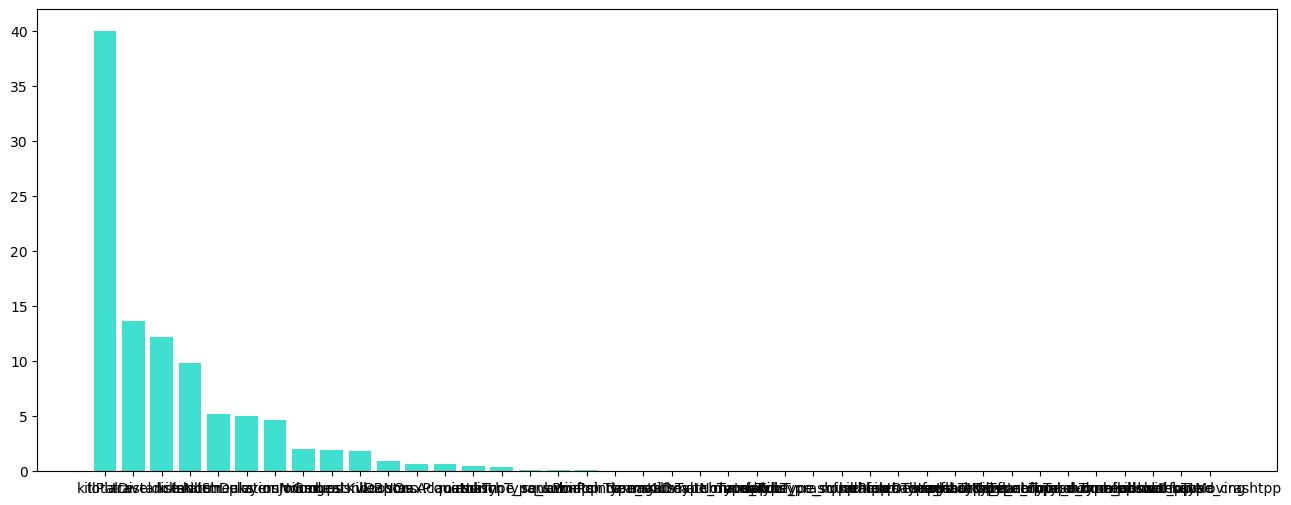

In [208]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color='turquoise')()
plt.ylabel("CatBoost feature Importance")
plt.xticks(rotation=90)
plt.show()

Prediction

In [211]:
pred=model.predict(xtest)

In [213]:
ytest[:10]

3289841    0.1786
1537261    0.9231
3529603    0.8723
3414934    0.5870
4135036    0.5926
626987     1.0000
2201649    0.4583
3478343    0.7500
3712192    0.3776
1850190    0.7200
Name: winPlacePerc, dtype: float64

In [215]:
pred[:10]

array([0.2316378 , 0.88345057, 0.84555107, 0.52371546, 0.57922852,
       0.96166423, 0.38173047, 0.7665135 , 0.32658477, 0.83829705])

In [223]:
rmse=np.sqrt(mean_squared_error(ytest,pred))
r2=r2_score(ytest, pred)#shows how much your model was relevant\

print("Testing Performance")
print("RMSE: {:.2f}". format(rmse))
print("R2: {:.2f}".format(r2))

Testing Performance
RMSE: 0.08
R2: 0.93


In [227]:
#rmse shows our prediction in only 8% wrong

<center><img src="https://media0.giphy.com/media/v1.Y2lkPTc5MGI3NjExamZ4YXF1NGhzN3M2c2dwenhtaG41NWo4ZTg5YWg1NzdiZjlkN24zYiZlcD12MV9naWZzX3NlYXJjaCZjdD1n/wOrKsd0Xre3zCQsFuV/giphy.webp"></center>